In [2]:
!pip3 install xgboost

In [180]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from sklearn.model_selection import GridSearchCV

from plotly.offline import iplot
import plotly.graph_objs as go



In [5]:
!gdown --id "1fDJptlCFEWNV5UNGPc4geTykgFI3PDCV"
!gdown --id "1pIO_nOg9XU0WUD10brRvrgyUXbY5gqMs"
!gdown --id "1lcxzVZ0-MkPmoH3lS35Q8rRfrecKSXb1"
!gdown --id "1_KN7S8zfHdrkRjRYOEtBxBVq8JrGxPXD"

Downloading...
From: https://drive.google.com/uc?id=1fDJptlCFEWNV5UNGPc4geTykgFI3PDCV
To: /content/storage_sample_stage4.h5
103MB [00:01, 65.6MB/s] 


In [11]:
from pandas import read_hdf
df_train = read_hdf('storage_sample_stage4.h5', 'train_df',mode='r')
df_test = read_hdf('storage_sample_stage4.h5', 'test_df',mode='r')

# Featurization


## Add missing Feature : num_followers_d

In [103]:
train_graph=nx.read_edgelist('train_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)

In [104]:
train_d_followers = [len(set(train_graph.predecessors(dest_node))) for dest_node in df_train["destination_node"].values]
test_d_followers = [len(set(train_graph.predecessors(dest_node))) for dest_node in df_test["destination_node"].values]

In [106]:
df_train["num_followers_d"] = train_d_followers
df_test["num_followers_d"] = test_d_followers

## Add Feature : Preferential Attachment


In [120]:
df_train["pref_attach_followees"] = df_train["num_followees_s"]*df_train["num_followees_d"]
df_train["pref_attach_followers"] = df_train["num_followers_s"]*df_train["num_followers_d"]

df_test["pref_attach_followees"] = df_test["num_followees_s"]*df_test["num_followees_d"]
df_test["pref_attach_followers"] = df_test["num_followers_s"]*df_test["num_followers_d"]

## Add Feature : svd_dot


In [109]:
def compute_svd_dot(df_row):
  svd_dot_u = (df_row["svd_u_s_1"]*df_row["svd_u_d_1"]) + \
              (df_row["svd_u_s_2"]*df_row["svd_u_d_2"]) + \
              (df_row["svd_u_s_3"]*df_row["svd_u_d_3"]) + \
              (df_row["svd_u_s_4"]*df_row["svd_u_d_4"]) + \
              (df_row["svd_u_s_5"]*df_row["svd_u_d_5"]) + \
              (df_row["svd_u_s_6"]*df_row["svd_u_d_6"])

  svd_dot_v = (df_row["svd_v_s_1"]*df_row["svd_v_d_1"]) + \
              (df_row["svd_v_s_2"]*df_row["svd_v_d_2"]) + \
              (df_row["svd_v_s_3"]*df_row["svd_v_d_3"]) + \
              (df_row["svd_v_s_4"]*df_row["svd_v_d_4"]) + \
              (df_row["svd_v_s_5"]*df_row["svd_v_d_5"]) + \
              (df_row["svd_v_s_6"]*df_row["svd_v_d_6"])

  return svd_dot_u, svd_dot_v


In [126]:
for index, row in tqdm(df_train.iterrows()):
  df_train.loc[index,"svd_dot_u"] ,df_train.loc[index,"svd_dot_v"]= compute_svd_dot(row)

for index, row in tqdm(df_test.iterrows()):
  df_test.loc[index,"svd_dot_u"] ,df_test.loc[index,"svd_dot_v"] = compute_svd_dot(row)


100002it [03:00, 554.21it/s]
50002it [01:03, 789.98it/s]


In [127]:
df_test.head(1)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,num_followers_d,pref_attach_followers,pref_attach_followees,svd_dot_u,svd_dot_v
0,848424,784690,1,0,0.0,0.029161,0.0,14,6,9,1,0,0.0,1,1,2,0.258199,0.377964,0.636163,0.09759,0.894362,1.014128,6.557971e-07,0.000002,0.000754,0.000786,3.243237e-16,1.745627e-16,2.969838e-15,9.269213e-14,-9.987979e-12,2.283676e-13,1.439968e-10,6.136162e-13,4.188171e-13,5.983361e-15,-1.026186e-11,5.316372e-13,5.843225e-10,1.166047e-13,2.253356e-11,3.220367e-15,-2.148852e-13,1.883148e-13,5.904807e-11,2.701538e-12,4.341620e-13,5.535503e-14,-9.994076e-10,5.791910e-10,3.512364e-07,2.486658e-09,2.771146e-09,1.727694e-12,18,252,54,8.425267e-20,2.074808e-17


In [128]:
# Save final train and test df 
df_train.to_csv("train_data.csv",index=False)
df_test.to_csv("test_data.csv",index=False)

# XGBOOST Algorithm

In [153]:
X_train = pd.read_csv("train_data.csv")
X_test = pd.read_csv("test_data.csv")
y_train = X_train.indicator_link
y_test = X_test.indicator_link

X_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
X_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

## Hyperparamater Tuning

In [186]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')

param_dist = {
'n_estimators': [1,5, 10],
'max_depth': [3, 5, 8],
}


hyp_clf = GridSearchCV(clf_xgb, param_dist,cv=5, scoring = 'f1', return_train_score = True)

In [187]:
hyp_clf.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [3, 5, 8], 'n_estimators': [1, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='f1

In [188]:
best_depth = hyp_clf.best_estimator_.max_depth
best_n = hyp_clf.best_estimator_.n_estimators

depth_vals = hyp_clf.cv_results_["param_max_depth"]
n_estimators_vals = hyp_clf.cv_results_["param_n_estimators"]
auc_vals_cv = hyp_clf.cv_results_["mean_test_score"]
auc_vals_train = hyp_clf.cv_results_["mean_train_score"]

In [191]:
print(best_depth, best_n)

8 10


In [190]:
#3d plot : max_depth vs n_estimators vs f1_score
trace1 = go.Scatter3d(x=depth_vals,y=n_estimators_vals,z=auc_vals_train, name = 'train')
trace2 = go.Scatter3d(x=depth_vals,y=n_estimators_vals,z=auc_vals_cv, name = 'Cross validation')
data = [trace1, trace2]
layout =  go.Layout(scene = dict(xaxis = dict(title='max_depth'),
          yaxis = dict(title='n_estimators'),
          zaxis = dict(title='f1_Score'),))
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='3d-scatter-colorscale')


## Model Building

In [198]:
best_model = xgb.XGBClassifier(objective = 'binary:logistic',max_depth=best_depth,n_estimators = best_n)
best_model.fit(X_train, y_train,eval_set=[(X_test, y_test)],eval_metric='auc')


[0]	validation_0-auc:0.954186
[1]	validation_0-auc:0.954272
[2]	validation_0-auc:0.953754
[3]	validation_0-auc:0.953282
[4]	validation_0-auc:0.953875
[5]	validation_0-auc:0.95379
[6]	validation_0-auc:0.95353
[7]	validation_0-auc:0.954014
[8]	validation_0-auc:0.954407
[9]	validation_0-auc:0.954795


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [200]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

## Evaluating Results

In [201]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9718951457100442
Test f1 score 0.9333727660653175


In [202]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


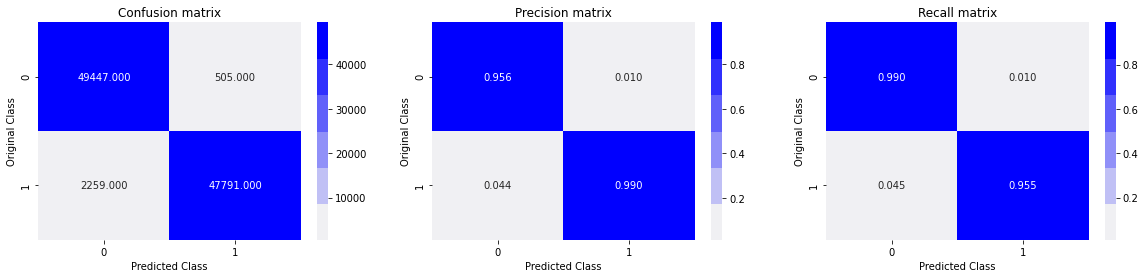

Test confusion_matrix


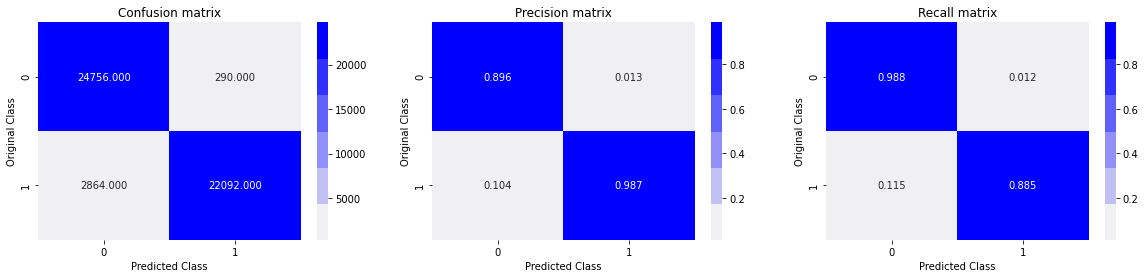

In [203]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

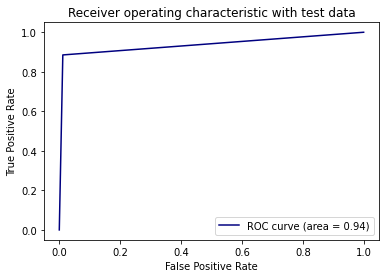

In [204]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

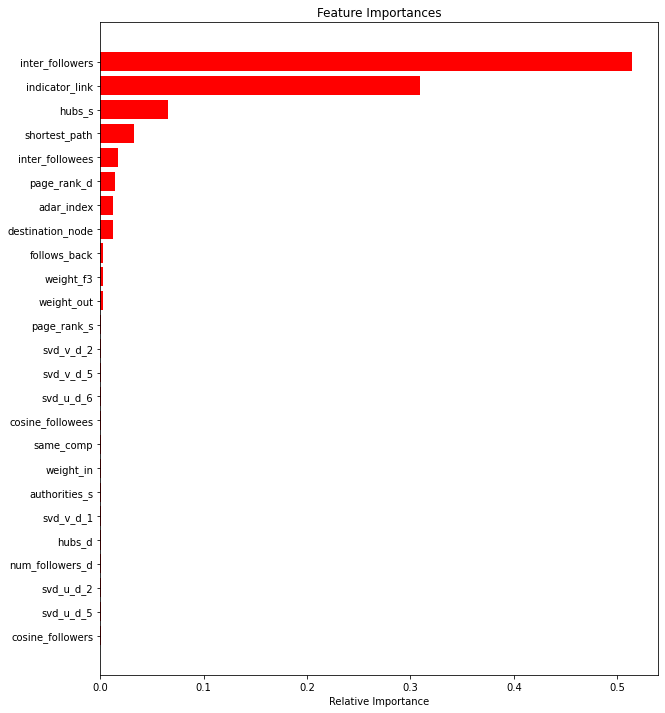

In [207]:
features = df_train.columns
importances = best_model.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Conclusion

<h2> STEPS Followed in the Case study</h2>

- Dataset Generation

  - Reading the dataset which is in the form <src_id,dest_id> . Let the indicator for the read points be = 1 (indicates src is connected to des)
  - Using the read dataset, create a Graph using the Nodes provided and each <src_id,dest_id> indicating an edge in the graph
  - Generate random <src,dest> pairs for which shortestPath(src,dest) > 2 and combine it with originally read dataset.The value of indicator is 0 (indicatind src and dest are not connected)

- Once dataset is generated, split it into Train Data (75%) and Test Data(25%)

<br>

<h2> Featurization Part : </h2>

The following features are calcualted and added as features
 -Followers and Followees of src and dest
  - Similarity Measures : Jaccards Coeficient, Otsuka-Ochia Coefficient
  - Page Rank
  - Whether Src and dest belong to same Weakly Connected Component
  - Adar Index
  - Katz Centrality
  - HITS
  - Use singular value decomposition to get U and V.T each of size (1,6) for src and dest
  - Weight Features
  - Preferential Attachment
  - SVD Dot features

<h2> Model Building </h2>

- The algorithm used here was XGBoost algorithm. 
- Hyperparamter tuning was done using Grid Search CV and the best parameters were found to be 
- max_depth=8,n_estimators = 10

<h2> Final Results : </h2>

- Train f1 score 0.9718951457100442
- Test f1 score 0.9333727660653175





